In [296]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import meerkat as mk
import numpy as np
import pandas as pd

In [261]:
mk.gui.start()

NetworkInfo(api=<fastapi.applications.FastAPI object at 0x15c47a760>, api_server_port=7864, api_server=<meerkat.interactive.server.Server object at 0x497db40d0>, npm_server_port=7865, npm_process=<subprocess.Popen object at 0x4b7620e20>, api_server_name='127.0.0.1', npm_server_name='localhost', npm_out_path='/var/folders/_w/s_61q82s15l0_06xwl0k83_40000gn/T/tmp7nltu_ut.out', npm_err_path='/var/folders/_w/s_61q82s15l0_06xwl0k83_40000gn/T/tmp_ibq0rjl.err')

In [2]:
# Load Racial Faces in the Wild and merge in CLIP embeddings for each image
rfw = mk.get('rfw', dataset_dir='/Users/krandiash/Desktop/workspace/projects/datasci/data/rfw/main/')
emb = mk.DataPanel.read('/Users/krandiash/Desktop/workspace/projects/datasci/data/rfw/rfw_embedded.mk')
dp = mk.merge(rfw, emb['clip(image)', 'image_id'], on='image_id')

/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/columns/file_column.py:275: FutureWarning: Reading a LambdaColumn stored in a format that will not be supported in the future. Please re-write the column to the new format.
  warnings.warn(
/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


In [3]:
# Load face embeddings + output of verification on positive pairs
face_embs = mk.DataPanel.read('/Users/krandiash/Desktop/workspace/projects/datasci/data/rfw/vgg-face-embeddings.mk')
verified_on_positive_pairs = mk.DataPanel.read('/Users/krandiash/Desktop/workspace/projects/datasci/data/rfw/vgg-verified-on-positive-pairs.mk/')

In [114]:
verified_on_positive_pairs

,identified (NumpyArrayColumn),distance (NumpyArrayColumn),threshold (NumpyArrayColumn)
0,True,0.376801,0.4
1,False,0.546332,0.4
2,True,0.328873,0.4
3,False,0.758516,0.4
4,True,0.263199,0.4
...,...,...,...
57148,False,0.861733,0.4
57149,True,0.256335,0.4
57150,False,0.458229,0.4
57151,False,0.679321,0.4


In [7]:
# Create positive pairs, with people having the same identity
rfw_positive_pairs = mk.merge(rfw, rfw, on='identity')
unique_pairs = rfw_positive_pairs['image_id_x'].str.split("_").str.get(-1) < rfw_positive_pairs['image_id_y'].str.split("_").str.get(-1)
rfw_positive_pairs = rfw_positive_pairs.lz[unique_pairs]

# Merge in the face embeddings for each image in the positive pairs
rfw_positive_pairs = mk.merge(mk.merge(rfw_positive_pairs, face_embs, left_on='image_id_x', right_on='image_id'), face_embs, left_on='image_id_y', right_on='image_id')

# Put in the verification results for each pair
for col in verified_on_positive_pairs.columns:
    rfw_positive_pairs[col] = verified_on_positive_pairs[col]

/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


In [239]:
# Reproduces the cosine distance function from DeepFace
def cosine_sim(x, y):
    return (x[:, None] @ y[:, :, None]).squeeze() / (np.linalg.norm(x, axis=1) * np.linalg.norm(y, axis=1))

def cosine_dist(x, y):
    return 1 - cosine_sim(x, y)

def run_verification(dp, threshold=0.4, classify_positive=True):
    # Calculate the cosine distance between the embeddings
    dp['distance'] = cosine_dist(dp['embed:vgg-face_x'], dp['embed:vgg-face_y'])

    # Calculate the verification result
    if classify_positive:
        dp['identified'] = dp['distance'] <= threshold
    else:
        dp['identified'] = dp['distance'] > threshold

    return dp

def create_negative_pairs(dp):
    # Create negative pairs, with people having different identities
    np.random.seed(42)

    _base_images = dp.lz[np.repeat(np.arange(dp.shape[0]), 5)]
    _base_images['idx'] = np.arange(_base_images.shape[0])
    _pair_images = dp.lz[np.random.randint(0, dp.shape[0], size=(dp.shape[0], 5)).flatten()]
    _pair_images['idx'] = np.arange(_pair_images.shape[0])
    dp_negative_pairs = mk.merge(_base_images, _pair_images, on='idx').drop('idx')

    # Merge in the face embeddings for each image in the negative pairs
    dp_negative_pairs = mk.merge(mk.merge(dp_negative_pairs, face_embs, left_on='image_id_x', right_on='image_id'), face_embs, left_on='image_id_y', right_on='image_id')

    return dp_negative_pairs

In [240]:
rfw_negative_pairs = create_negative_pairs(rfw)
rfw_negative_pairs = run_verification(rfw_negative_pairs, classify_positive=False)

indian_negative_pairs = create_negative_pairs(rfw.lz[rfw['ethnicity'] == 'indian'])
african_negative_pairs = create_negative_pairs(rfw.lz[rfw['ethnicity'] == 'african'])

indian_negative_pairs = run_verification(indian_negative_pairs, classify_positive=False)
african_negative_pairs = run_verification(african_negative_pairs, classify_positive=False)

/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is de

<AxesSubplot:>

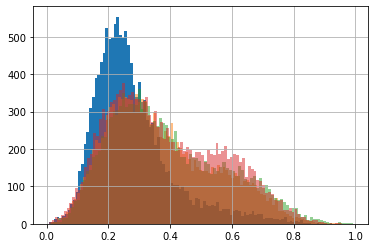

In [169]:
rfw_positive_pairs.lz[rfw_positive_pairs['ethnicity_x'] == 'african']['distance'].to_pandas().hist(bins=100)
rfw_positive_pairs.lz[rfw_positive_pairs['ethnicity_x'] == 'indian']['distance'].to_pandas().hist(bins=100, alpha=0.5)
rfw_positive_pairs.lz[rfw_positive_pairs['ethnicity_x'] == 'caucasian']['distance'].to_pandas().hist(bins=100, alpha=0.5)
rfw_positive_pairs.lz[rfw_positive_pairs['ethnicity_x'] == 'asian']['distance'].to_pandas().hist(bins=100, alpha=0.5)

<AxesSubplot:>

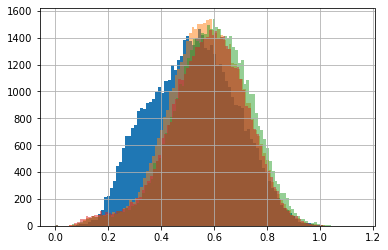

In [227]:
rfw_negative_pairs.lz[rfw_negative_pairs['ethnicity_x'] == 'african']['distance'].to_pandas().hist(bins=100)
rfw_negative_pairs.lz[rfw_negative_pairs['ethnicity_x'] == 'indian']['distance'].to_pandas().hist(bins=100, alpha=0.5)
rfw_negative_pairs.lz[rfw_negative_pairs['ethnicity_x'] == 'caucasian']['distance'].to_pandas().hist(bins=100, alpha=0.5)
rfw_negative_pairs.lz[rfw_negative_pairs['ethnicity_x'] == 'asian']['distance'].to_pandas().hist(bins=100, alpha=0.5)

In [243]:
# Calculate the FNMR
def aggregate_verification_results(pair_dp, column_name='identified', new_col='fnmr', invert=True, separate_identity=False):
    if separate_identity:
        left_identity_col = 'identity_x'
        right_identity_col = 'identity_y'
    else:
        left_identity_col = 'identity'
        right_identity_col = 'identity'
    left_gb = pair_dp[left_identity_col, column_name, 'image_id_x'].groupby('image_id_x')
    right_gb = pair_dp[right_identity_col, column_name, 'image_id_y'].groupby('image_id_y') 

    temp_count = mk.merge(left_gb[column_name].count(), right_gb[column_name].count(), left_on='image_id_x', right_on='image_id_y', how='outer')
    temp_mean = mk.merge(left_gb[column_name].mean(), right_gb[column_name].mean(), left_on='image_id_x', right_on='image_id_y', how='outer')
    temp_count['image_id'] = [a if a else b for (a,b) in zip(temp_count['image_id_x'], temp_count['image_id_y'])]
    temp_count['count'] = pd.Series(temp_count[f'{column_name}_x'].data).fillna(0, inplace=False) + pd.Series(temp_count[f'{column_name}_y'].data).fillna(0, inplace=False)
    temp_mean['image_id'] = [a if a else b for (a,b) in zip(temp_mean['image_id_x'], temp_mean['image_id_y'])]
    temp_mean[new_col] = (pd.Series(temp_count[f'{column_name}_x'].data).fillna(0, inplace=False) * pd.Series(temp_mean[f'{column_name}_x'].data).fillna(0, inplace=False) + pd.Series(temp_count[f'{column_name}_y'].data).fillna(0, inplace=False) * pd.Series(temp_mean[f'{column_name}_y'].data).fillna(0, inplace=False))/temp_count['count']
    if invert: temp_mean[new_col] = 1 - temp_mean[new_col]
    temp_mean['count'] = temp_count['count']
    return temp_mean['image_id', new_col, 'count']

In [249]:
rfw_fnmr_by_image_id = aggregate_verification_results(rfw_positive_pairs)
rfw_neg_fnmr_by_image_id = aggregate_verification_results(rfw_negative_pairs, invert=False, separate_identity=True)
indian_neg_fnmr_by_image_id = aggregate_verification_results(indian_negative_pairs, invert=False, separate_identity=True)
african_neg_fnmr_by_image_id = aggregate_verification_results(african_negative_pairs, invert=False, separate_identity=True)

/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is de

In [250]:
rfw_fnmr_by_image_id = mk.merge(dp, rfw_fnmr_by_image_id, on='image_id')

rfw_distance_by_image_id = aggregate_verification_results(rfw_positive_pairs, column_name='distance', new_col='distance', invert=False)
rfw_fnmr_by_image_id = mk.merge(rfw_fnmr_by_image_id, rfw_distance_by_image_id, on='image_id')

/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


In [251]:
rfw_neg_fnmr_by_image_id = mk.merge(dp, rfw_neg_fnmr_by_image_id, on='image_id')
indian_neg_fnmr_by_image_id = mk.merge(dp, indian_neg_fnmr_by_image_id, on='image_id')
african_neg_fnmr_by_image_id = mk.merge(dp, african_neg_fnmr_by_image_id, on='image_id')

/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():
/Users/krandiash/Desktop/workspace/projects/meerkat/meerkat/ops/merge.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in merged_df.iteritems():


In [252]:
print("Global Average FNMR across all images: ", rfw_fnmr_by_image_id['fnmr'].mean())
rfw_fnmr_by_image_id.groupby('ethnicity')['fnmr'].mean()

Global Average FNMR across all images:  0.3367147698005377


,fnmr (NumpyArrayColumn),ethnicity (PandasSeriesColumn)
0,0.14145,african
1,0.419279,asian
2,0.415058,caucasian
3,0.378433,indian


In [254]:
print("Global Average Precision across all images: ", rfw_neg_fnmr_by_image_id['fnmr'].mean())
rfw_neg_fnmr_by_image_id.groupby('ethnicity')['fnmr'].mean()

Global Average Precision across all images:  0.8590122950167786


,fnmr (NumpyArrayColumn),ethnicity (PandasSeriesColumn)
0,0.751778,african
1,0.8918,asian
2,0.908744,caucasian
3,0.887073,indian


In [256]:
indian_neg_fnmr_by_image_id['fnmr'].mean(), african_neg_fnmr_by_image_id['fnmr'].mean()

(0.8562336726376323, 0.2966388244275477)

In [319]:
indian_dp = rfw_fnmr_by_image_id.lz[rfw_fnmr_by_image_id['ethnicity'] == 'indian']
african_dp = rfw_fnmr_by_image_id.lz[rfw_fnmr_by_image_id['ethnicity'] == 'african']
caucasian_dp = rfw_fnmr_by_image_id.lz[rfw_fnmr_by_image_id['ethnicity'] == 'caucasian']
asian_dp = rfw_fnmr_by_image_id.lz[rfw_fnmr_by_image_id['ethnicity'] == 'asian']

In [266]:
indian_neg_eb = indian_neg_fnmr_by_image_id.explainby(by='image', target='fnmr', n_slices=50, use_cache=False)
indian_neg_eb.gui.cards(main_column='image', tag_columns=['ethnicity', 'fnmr'], aggregations={"Mean Precision": lambda x: x["fnmr"].mean()})

(10281, 1)


 80%|████████  | 80/100 [00:03<00:00, 20.06it/s]


In [265]:
african_neg_eb = african_neg_fnmr_by_image_id.explainby(by='image', target='fnmr', n_slices=20, use_cache=False)
african_neg_eb.gui.cards(main_column='image', tag_columns=['ethnicity', 'fnmr'], aggregations={"Mean Precision": lambda x: x["fnmr"].mean()})

(10378, 1)


 27%|██▋       | 27/100 [00:01<00:03, 20.81it/s]


In [313]:
np.random.seed(42)
eb = indian_dp.explainby(by='image', target='fnmr', n_slices=20, use_cache=False)
eb.gui.cards(main_column='image', tag_columns=['ethnicity', 'fnmr'], aggregations={"Mean FNMR": lambda x: x["fnmr"].mean(), "Mean Distance": lambda x: x["distance"].mean()})

(10278, 1)


 54%|█████▍    | 54/100 [00:07<00:06,  7.14it/s]


In [294]:
def run_precision_workflow(query_dp):
    query_dp = create_negative_pairs(query_dp)
    query_dp = run_verification(query_dp, classify_positive=False)
    query_dp = aggregate_verification_results(query_dp, invert=False, separate_identity=True)
    query_dp = mk.merge(dp, query_dp, on='image_id')
    return query_dp['fnmr'].mean()

In [317]:
# Indians wearing Nehru cap
indian_nehru_cap = indian_dp.lz[eb.slices[3]]
print("Precision on Nehru Cap Group", run_precision_workflow(indian_nehru_cap))
print("FNMR", indian_nehru_cap['fnmr'].mean())

# Indian women wearing makeup / traditional jewelery
indian_women_trad = indian_dp.lz[eb.slices[0]]
print("Precision on indian women trad makeup jewelery", run_precision_workflow(indian_women_trad))
print("FNMR", indian_women_trad['fnmr'].mean())

# Older indian women
indian_older_women = indian_dp.lz[eb.slices[18]]
print("Precision on Indian Older women", run_precision_workflow(indian_older_women))
print("FNMR", indian_older_women['fnmr'].mean())

# Older white haired indian men
indian_older_men = indian_dp.lz[eb.slices[7]]
print("Precision on Indian Older men", run_precision_workflow(indian_older_men))
print("FNMR", indian_older_men['fnmr'].mean())

# Indian men in suits
indian_men_suits = indian_dp.lz[eb.slices[13]]
print("Precision on Indian men in suits", run_precision_workflow(indian_men_suits))
print("FNMR", indian_men_suits['fnmr'].mean())

# Sikhs
sikh_dp = indian_dp.lz[eb.slices[6]]
print("Precision on Sikh Group", run_precision_workflow(sikh_dp))
print("FNMR", sikh_dp['fnmr'].mean())

Precision on Nehru Cap Group 0.4832504377814225
FNMR 0.17943548387096775
Precision on indian women trad makeup jewelery 0.7030274825356793
FNMR 0.48394808743169404
Precision on Indian Older women 0.7108996391333376
FNMR 0.4220313441832429
Precision on Indian Older men 0.29565815047401445
FNMR 0.2535882908404155
Precision on Indian men in suits 0.6070768999519
FNMR 0.2962222222222222
Precision on Sikh Group 0.5548554320053379
FNMR 0.1505952380952381


In [314]:
for key in eb.slices:
    print(key, run_precision_workflow(indian_dp.lz[eb.slices[key]]))

0 0.7030274825356793
1 0.6973066597705515
2 0.7602324479736056
3 0.4832504377814225
4 0.8030110447730273
5 0.8279199105179498
6 0.5548554320053379
7 0.29565815047401445
8 0.6918367313606788
9 0.5660385540385541
10 0.486654761530302
11 0.8183520571808685
12 0.8249456583499704
13 0.6070768999519
14 0.7729257366249986
15 0.8084310197378379
16 0.8091530861645804
17 0.6412843679679535
18 0.7108996391333376
19 0.8688837887071982


Precision on Sikh Group 0.5507325660760094


In [268]:
indian_eb_dist = indian_dp.explainby(by='image', target='distance', n_slices=20, use_cache=False)
indian_eb_dist.gui.cards(main_column='image', tag_columns=['ethnicity', 'fnmr'], aggregations={"Mean FNMR": lambda x: x["fnmr"].mean(), "Mean Distance": lambda x: x["distance"].mean()})

(10278, 1)


 31%|███       | 31/100 [00:01<00:03, 19.75it/s]


In [305]:
np.random.seed(42)
african_eb = african_dp.explainby(by='image', target='fnmr', n_slices=50, use_cache=False)
african_eb.gui.cards(main_column='image', tag_columns=['ethnicity', 'fnmr'], aggregations={"Mean FNMR": lambda x: x["fnmr"].mean(), "Mean Distance": lambda x: x["distance"].mean(), "Count": lambda x: len(x)})

(10378, 1)


 31%|███       | 31/100 [00:01<00:03, 20.71it/s]


In [311]:
for key in african_eb.slices:
    print(key, run_precision_workflow(african_dp.lz[african_eb.slices[key]]))

0 0.14317690938761432
1 0.16847329446064682
2 0.2233374770741319
3 0.24640835220586352
4 0.2404430537317276
5 0.4235646109866457
6 0.1061695520494403
7 0.1966245304940158
8 0.22388090495675633
9 0.3215337382222199
10 0.18740007073340406
11 0.30960822636959007
12 0.10690237681596082
13 0.1215811535544592
14 0.6292800470101726
15 0.28217767046750564
16 0.33437508041210434
17 0.4809933836168404
18 0.10431171696415599
19 0.3051903231448686
20 0.1190555751249393
21 0.1586736795107491
22 0.18176598607154165
23 0.2647648805156545
24 0.16554015942904832


In [318]:

# Bald and older African males in suits or traditional attire and headwear
bald_africans_in_suits = african_dp.lz[african_eb.slices[18]]
# bald_african_eb = bald_africans_in_suits.explainby(by='image', target='fnmr', n_slices=5, use_cache=False)
# bald_african_eb.gui.cards(main_column='image', tag_columns=['ethnicity', 'fnmr'], aggregations={"Mean FNMR": lambda x: x["fnmr"].mean(), "Mean Distance": lambda x: x["distance"].mean(), "Count": lambda x: len(x)})
print("Precision on Bald Africans in Suits Group", run_precision_workflow(bald_africans_in_suits))
print("FNMR", bald_africans_in_suits['fnmr'].mean())

# African soccer players on the field
african_soccer = african_dp.lz[african_eb.slices[6]]
print("Precision on African soccer players", run_precision_workflow(african_soccer))
print("FNMR", african_soccer['fnmr'].mean())

# African basketball players
african_basketball = african_dp.lz[african_eb.slices[20]]
print("Precision on African basketball players", run_precision_workflow(african_basketball))
print("FNMR", african_basketball['fnmr'].mean())

# Old-timey photos
african_old_photos = african_dp.lz[african_eb.slices[19]]
print("Precision on African old time photos", run_precision_workflow(african_old_photos))
print("FNMR", african_old_photos['fnmr'].mean())

# African women
african_women = african_dp.lz[african_eb.slices[14]]
print("Precision on African women", run_precision_workflow(african_women))
print("FNMR", african_women['fnmr'].mean())

# Forward facing photos taken for (male) athletes
forward_african_athletes = african_dp.lz[african_eb.slices[1]]
print("Precision on Forward Facing Athletes Group", run_precision_workflow(forward_african_athletes))
print("FNMR", forward_african_athletes['fnmr'].mean())

# (Male) African boxers and fighters
african_fighters = african_dp.lz[african_eb.slices[13]]
print("Precision on African Fighters and Boxers Group", run_precision_workflow(african_fighters))
print("FNMR", african_fighters['fnmr'].mean())

Precision on Bald Africans in Suits Group 0.10431171696415599
FNMR 0.07669376693766938
Precision on African soccer players 0.1061695520494403
FNMR 0.11145251396648047
Precision on African basketball players 0.1190555751249393
FNMR 0.11030828516377651
Precision on African old time photos 0.3051903231448686
FNMR 0.16535353535353536
Precision on African women 0.6292800470101726
FNMR 0.3145048814504881
Precision on Forward Facing Athletes Group 0.16847329446064682
FNMR 0.12724814063556458
Precision on African Fighters and Boxers Group 0.1215811535544592
FNMR 0.0904891304347826


In [320]:
np.random.seed(42)
caucasian_eb = caucasian_dp.explainby(by='image', target='fnmr', n_slices=20, use_cache=False)
caucasian_eb.gui.cards(main_column='image', tag_columns=['ethnicity', 'fnmr'], aggregations={"Mean FNMR": lambda x: x["fnmr"].mean(), "Mean Distance": lambda x: x["distance"].mean(), "Count": lambda x: len(x)})

(10196, 1)


 53%|█████▎    | 53/100 [00:11<00:09,  4.71it/s]


In [321]:
for key in caucasian_eb.slices:
    print(key, run_precision_workflow(caucasian_dp.lz[caucasian_eb.slices[key]]))

0 0.8827819018714742
1 0.7793922517391905
2 0.7056854285170612
3 0.8583418907948719
4 0.7807834782122683
5 0.5924132406433291
6 0.9187555780288045
7 0.699390146964433
8 0.8795777306472494
9 0.7951360610049357
10 0.9176855580056801
11 0.7927401860591514
12 0.7871765727464257
13 0.7702191555024066
14 0.8227482416820653
15 0.6691426244325103
16 0.8996672848283276
17 0.3647411245085664
18 0.5838159161786988
19 0.9395909406094592


In [322]:
np.random.seed(42)
asian_eb = asian_dp.explainby(by='image', target='fnmr', n_slices=20, use_cache=False)
asian_eb.gui.cards(main_column='image', tag_columns=['ethnicity', 'fnmr'], aggregations={"Mean FNMR": lambda x: x["fnmr"].mean(), "Mean Distance": lambda x: x["distance"].mean(), "Count": lambda x: len(x)})

(9676, 1)


 37%|███▋      | 37/100 [00:02<00:03, 16.20it/s]


In [323]:
for key in asian_eb.slices:
    print(key, run_precision_workflow(asian_dp.lz[asian_eb.slices[key]]))

0 0.4633737244586301
1 0.6625442545386365
2 0.6087581784412771
3 0.798914261907683
4 0.5865012415171135
5 0.6045568942692837
6 0.6763531688899336
7 0.8677791586446703
8 0.7719199988789541
9 0.7159912783615205
10 0.582141283018476
11 0.47179107784576535
12 0.6073507067513917
13 0.7366671961499548
14 0.7850620322807607
15 0.6062296289569016
16 0.6863554548632609
17 0.6630824471640301
18 0.6198134750419549
19 0.5999367584330909


In [36]:
true_match_rate_by_identity = rfw_positive_pairs['identity', 'identified', 'image_id_x'].groupby('identity').mean()
true_match_rate_by_identity['fnmr'] = 1 - true_match_rate_by_identity['identified']
true_match_rate_by_identity = true_match_rate_by_identity['identity', 'fnmr']
true_match_rate_by_identity

,identity (PandasSeriesColumn),fnmr (NumpyArrayColumn)
0,m.010g87,1.0
1,m.010lz5,0.0
2,m.0112yl,0.666667
3,m.01167d3z,0.0
4,m.011_2h,0.666667
...,...,...
11402,m.0xsk8,0.5
11403,m.0ywm0,1.0
11404,m.0ywsp,0.0
11405,m.0z1z,0.5


In [52]:
# Average embedding per identity
avg_embs_clip_by_identity = dp['identity', 'clip(image)'].groupby('identity')['clip(image)'].mean(axis=0)

In [55]:
avg_embs_clip_by_identity

,clip(image) (NumpyArrayColumn),identity (PandasSeriesColumn)
0,"np.ndarray(shape=(512,))",m.010g87
1,"np.ndarray(shape=(512,))",m.010lz5
2,"np.ndarray(shape=(512,))",m.0112yl
3,"np.ndarray(shape=(512,))",m.01167d3z
4,"np.ndarray(shape=(512,))",m.011_2h
...,...,...
11407,"np.ndarray(shape=(512,))",m.0xsk8
11408,"np.ndarray(shape=(512,))",m.0ywm0
11409,"np.ndarray(shape=(512,))",m.0ywsp
11410,"np.ndarray(shape=(512,))",m.0z1z
